### Import Modules

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from datetime import timedelta

### Read In Data

In [41]:
usecols = [1,2,3,5,11,17,19,20,21,22,23]

In [42]:
df_iowa = pd.read_csv("//datasets/Iowa_Liquor_Sales.csv", usecols = usecols)

In [43]:
df_iowa.columns

Index(['Date', 'Store Number', 'Store Name', 'City', 'Category Name',
       'Bottle Volume (ml)', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

In [44]:
df_iowa['Date'] = pd.to_datetime(df_iowa['Date'])
df_iowa['Year'] = df_iowa['Date'].dt.year
df_iowa['Month'] = df_iowa['Date'].dt.month

### Subset Data

In [45]:
data_years = [2020,2021,2022,2023]

In [46]:
df_sub = df_iowa[df_iowa['Year'].isin(data_years)]

In [47]:
df_sub.shape

(6891949, 13)

## Data Cleaning

### Store Names

In [48]:
def clean_store_names(store):
    
    store = store.split('/')[0].split('#')[0].lower().rstrip(' ')
    
    if (store.find('wal-mart') != -1) or (store == 'W-Mart'):
        return 'walmart'
    
    if store.find('target store t') != -1:
        return 'target'
    
    if store.find("sam's club") != -1:
        return "sam's club"
    
    if store.find('hy-vee') != -1:
        return 'hy-vee'
    
    if store.find('central city') != -1:
        return 'central city'
    
    return store

In [49]:
df_sub.loc[:,'Store Name'] = df_sub['Store Name'].apply(clean_store_names)

### Alcohol Category Name

We can potentially use this as different response variables to see if the effects of the explanatory variables are for the different types of alcohol 

In [50]:
def clean_cats(cat):
    cat = cat.lower()
    if (cat.find('whiskies') != -1) or (cat.find('whiskey') != -1):
        return 'whiskey'
    if (cat.find('vodka') != -1) or (cat.find('vodkas') != -1):
        return 'vodka'
    if (cat.find('tequila') != -1):
        return 'tequila'
    if (cat.find('gin') != -1):
        return 'gin'
    if (cat.find('rum') != -1):
        return 'rum'
    if (cat.find('liqueurs') != -1) or (cat.find('liqueur') != -1):
        return 'liqueur'
    if (cat.find('schnapps') != -1) or (cat.find('schnapp') != -1):
        return 'schnapps'
    if (cat.find('spirit') != -1):
        return 'spirit'
    if (cat.find('cocktail') != -1):
        return 'cocktail'
    if (cat.find('brandies') != -1) or (cat.find('brandy') != -1):
        return 'brandy'
    if (cat.find('scotch') != -1):
        return 'scotch'
    if (cat.find('bourbon') != -1):
        return 'bourbon'
    return 'other'

In [51]:
df_sub['Category Name'] = df_sub['Category Name'].astype(str).apply(clean_cats)
df_sub.head()

<ipython-input-51-12ea0e9ec2c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['Category Name'] = df_sub['Category Name'].astype(str).apply(clean_cats)


,Date,Store Number,Store Name,City,Category Name,Bottle Volume (ml),State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Month
11875780,2020-01-02,4404.0,kum & go,Ankeny,whiskey,375.0,12.00,2.0,24.00,0.75,0.19,2020.0,1.0
11875781,2020-01-02,5257.0,mad ave quik shop,Ottumwa,vodka,1000.0,6.08,12.0,72.96,12.00,3.17,2020.0,1.0
11875782,2020-01-03,5529.0,big 10 mart,Dubuque,brandy,200.0,3.00,8.0,24.00,1.60,0.42,2020.0,1.0
11875783,2020-01-06,2524.0,hy-vee,Dubuque,tequila,1000.0,11.75,12.0,141.00,12.00,3.17,2020.0,1.0
11875784,2020-01-07,2643.0,hy-vee,Waterloo,vodka,200.0,1.73,6.0,10.38,1.20,0.31,2020.0,1.0


## Feature Engineering

### City Population Feature Engineering

The goal of this feature engineering is to create a categorical variable which can be used to measure the size of a city's population

In [52]:
def clean_cities(city):
    city = city.lower()
    if city == 'clearlake':
        return 'clear lake'
    elif city == 'mt pleasant':
        return 'mount pleasant'
    elif city == 'lemars':
        return 'le mars'
    elif city == 'saint ansgar':
        return 'st ansgar'
    elif city == 'leclaire':
        return 'le claire'
    elif city == 'jewell':
        return 'jewell junction'
    elif city == "arnold's park":
        return 'arnolds park'
    elif city == 'grand mounds':
        return 'grand mound'
    elif city == 'lonetree':
        return 'lone tree'
    elif city == 'otumwa':
        return 'ottumwa'
    else:
        return city

In [53]:
df_sub.loc[:,'City'] = df_sub['City'].astype(str).apply(clean_cities)

Iowa_city.csv is an external dataset which contains the populations for different cities in Iowa. We will be joining this dataset to the Iowa beer data so we can work with the population numbers

In [54]:
df_cities = pd.read_csv("https://raw.githubusercontent.com/brendad8/Datasets/main/Iowa_City.csv")

In [55]:
df_cities['population'] = df_cities['population'].str.replace(",", "").astype(int)
df_cities['name'] = df_cities['name'].str.replace(" city", "").str.lower()
df_cities['name'] = df_cities['name'].str.replace(".", "")
df_cities['name'] = df_cities['name'].str.replace(" cdp", "")

In [56]:
df_sub = df_sub.merge(df_cities, left_on = 'City', right_on = 'name', how='left')

In [57]:
df_sub.dropna(inplace=True)

In [58]:
df_sub.shape

(6889245, 15)

In [59]:
def map_city_pop(pop):
    if pop >= 100000:
        return '6'
    else:
        if pop >= 50000:
            return '5'
        else:
            if pop >= 20000:
                return '4'
            else:
                if pop >= 10000:
                    return '3'
                else:
                    if pop >= 1000:
                        return '2'
                    else:
                        return '1'

In [60]:
df_sub.loc[:,'Pop_Bracket'] = df_sub['population'].apply(map_city_pop)

#### Plot using new Population Bracket Variable

<Axes: xlabel='Pop_Bracket'>

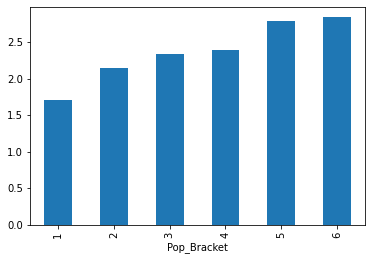

In [61]:
df_sub.groupby(['Pop_Bracket'])['Volume Sold (Gallons)'].mean().plot.bar()

This plot shows that stores in cities with larger populations tend to purchase more gallons of alcohol for their stores. This is pretty obvious and may come in handy when interpreting other predictors. Ex. Adjusting for population of the city, this var is associated with...

### Weekday vs Weekend Feature Engineering

The goal of this section was to create 2 variables:

1. A variable for the day of the week --> monday=1, tuesday=2, ...
2. A variable to indicate whether the day was on the weekend
    
Note: we are including Friday as part of the weekend

In [62]:
df_sub['DayofWeekInt'] = df_sub['Date'].dt.dayofweek
df_sub["DayofWeek"] = df_sub["DayofWeekInt"].map({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"})
df_sub["Weekend_or_Weekday"] = df_sub["DayofWeekInt"].map({0:"Weekday", 1:"Weekday", 2:"Weekday", 3:"Weekday", 4:"Weekend", 5:"Weekend", 6:"Weekend"})
df_sub = df_sub.drop(columns="DayofWeekInt")
df_sub.head()

,Date,Store Number,Store Name,City,Category Name,Bottle Volume (ml),State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Month,name,population,Pop_Bracket,DayofWeek,Weekend_or_Weekday
0,2020-01-02,4404.0,kum & go,ankeny,whiskey,375.0,12.00,2.0,24.00,0.75,0.19,2020.0,1.0,ankeny,72222.0,5,Thursday,Weekday
1,2020-01-02,5257.0,mad ave quik shop,ottumwa,vodka,1000.0,6.08,12.0,72.96,12.00,3.17,2020.0,1.0,ottumwa,25175.0,4,Thursday,Weekday
2,2020-01-03,5529.0,big 10 mart,dubuque,brandy,200.0,3.00,8.0,24.00,1.60,0.42,2020.0,1.0,dubuque,58873.0,5,Friday,Weekend
3,2020-01-06,2524.0,hy-vee,dubuque,tequila,1000.0,11.75,12.0,141.00,12.00,3.17,2020.0,1.0,dubuque,58873.0,5,Monday,Weekday
4,2020-01-07,2643.0,hy-vee,waterloo,vodka,200.0,1.73,6.0,10.38,1.20,0.31,2020.0,1.0,waterloo,66562.0,5,Tuesday,Weekday


#### Plots using new Weekend / Day of Week Variables

<Axes: xlabel='Weekend_or_Weekday'>

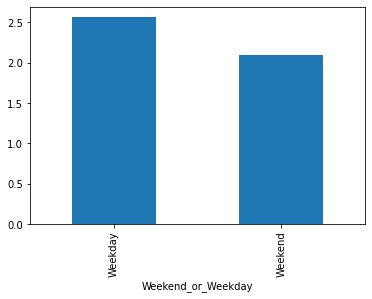

In [63]:
df_sub.groupby('Weekend_or_Weekday')['Volume Sold (Gallons)'].mean().plot.bar()

<Axes: xlabel='DayofWeek'>

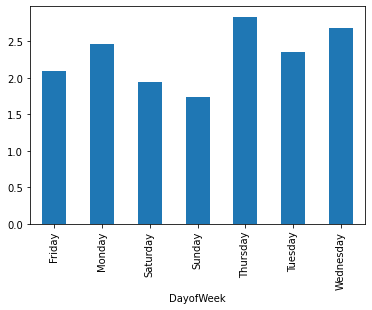

In [64]:
df_sub.groupby('DayofWeek')['Volume Sold (Gallons)'].mean().plot.bar()

### Major College Town Feature Engineering

The two largest public universities in Iowa are Iowa State University and University of Iowa which are in Ames and Iowa City respectively

The goal of this feature engineering is to create a variable which indicates whether a liquor store is in one of these college cites/towns.

In [65]:
def is_major_college_town(city):
    if city in ["ames", "iowa city"]:
        return 1
    else:
        return 0

In [66]:
df_sub['major_college_town'] = df_sub['City'].apply(is_major_college_town)
df_sub.head()

,Date,Store Number,Store Name,City,Category Name,Bottle Volume (ml),State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Month,name,population,Pop_Bracket,DayofWeek,Weekend_or_Weekday,major_college_town
0,2020-01-02,4404.0,kum & go,ankeny,whiskey,375.0,12.00,2.0,24.00,0.75,0.19,2020.0,1.0,ankeny,72222.0,5,Thursday,Weekday,0
1,2020-01-02,5257.0,mad ave quik shop,ottumwa,vodka,1000.0,6.08,12.0,72.96,12.00,3.17,2020.0,1.0,ottumwa,25175.0,4,Thursday,Weekday,0
2,2020-01-03,5529.0,big 10 mart,dubuque,brandy,200.0,3.00,8.0,24.00,1.60,0.42,2020.0,1.0,dubuque,58873.0,5,Friday,Weekend,0
3,2020-01-06,2524.0,hy-vee,dubuque,tequila,1000.0,11.75,12.0,141.00,12.00,3.17,2020.0,1.0,dubuque,58873.0,5,Monday,Weekday,0
4,2020-01-07,2643.0,hy-vee,waterloo,vodka,200.0,1.73,6.0,10.38,1.20,0.31,2020.0,1.0,waterloo,66562.0,5,Tuesday,Weekday,0


#### Plot using new Major College Town variable

<Axes: xlabel='major_college_town'>

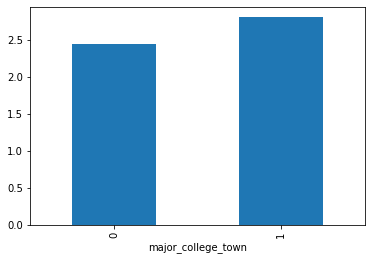

In [67]:
df_sub.groupby(['major_college_town'])['Volume Sold (Gallons)'].mean().plot.bar()

From the plot we see a slight increase in the mean volume of alc purchased by liquor stores in cities with major colleges. This is something we definitely wanna check out in our regression model.

### Season Feature Engineering

The goal of this feature engineering is to create a variable which determines the season in which a liquor store purchased alcohol. The goal is to determine whether there are seasonal increases/decreases in alcohol consumption.

We are gonna make the assumption that:
* spring runs from beginning of March to the end of May
* summer runs from the beginning of June to the end of August
* fall runs from the beginning of September to the end of November
* winter runs from the beginning of December to the end of February

In [68]:
def map_season(month):
    if month in [12,1,2]:
        return 'winter'
    elif month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    else:
        return 'fall'

In [69]:
df_sub['season'] = df_sub['Month'].apply(map_season)

#### Plot using new season variable

<Axes: xlabel='season'>

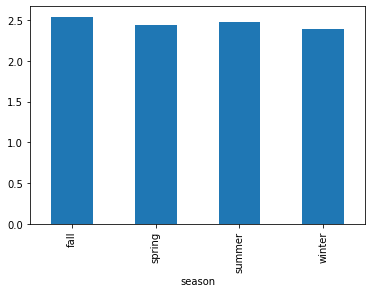

In [70]:
df_sub.groupby('season')['Volume Sold (Gallons)'].mean().plot.bar()

### Holiday Feature Engineering

The goal of this feature engineering is to determine whether the day a liquor store purchased alcohol is within 10 days before a holiday

In [71]:
us_holidays = holidays.UnitedStates(years = data_years).items()
df_holidays = pd.DataFrame.from_dict(us_holidays).rename(columns={0:'Date', 1:'Holiday'})

df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays['Year'] = df_holidays['Date'].dt.year

keep_holidays = ["New Year's Day", "Memorial Day", 'Independence Day', 'Labor Day', 'Veterans Day', 'Thanksgiving', 'Christmas Day']
df_holidays = df_holidays[df_holidays['Holiday'].isin(keep_holidays)]

In [72]:
df_holidays.head()

,Date,Holiday,Year
3,2020-01-01,New Year's Day,2020
4,2020-05-25,Memorial Day,2020
5,2020-07-04,Independence Day,2020
7,2020-09-07,Labor Day,2020
8,2020-11-11,Veterans Day,2020


Here we are getting all the days that are 10 days before a holiday. So for each holiday date included in the dataset, we are adding the 10 days before that date to a list of dates. We are then joining that list of dates to our data to assign those days a value of 1 for the new variable. The leftover days will be nan so we want to replace those values with 0

In [73]:
holidayWeekDays = []

for holiday in df_holidays['Date']:
    for i in range(10):
        holidayWeekDays.append(pd.to_datetime((holiday - timedelta(days=i))))

df_holiday_week = pd.DataFrame(columns = ['Date'], data = holidayWeekDays)
df_holiday_week['Holiday_10'] = 1

In [74]:
df_sub = df_sub.merge(df_holiday_week, on='Date', how='left')

In [75]:
df_sub['Holiday_10'] = df_sub['Holiday_10'].fillna(0)
df_sub.head()

,Date,Store Number,Store Name,City,Category Name,Bottle Volume (ml),State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),...,Year,Month,name,population,Pop_Bracket,DayofWeek,Weekend_or_Weekday,major_college_town,season,Holiday_10
0,2020-01-02,4404.0,kum & go,ankeny,whiskey,375.0,12.00,2.0,24.00,0.75,...,2020.0,1.0,ankeny,72222.0,5,Thursday,Weekday,0,winter,0.0
1,2020-01-02,5257.0,mad ave quik shop,ottumwa,vodka,1000.0,6.08,12.0,72.96,12.00,...,2020.0,1.0,ottumwa,25175.0,4,Thursday,Weekday,0,winter,0.0
2,2020-01-03,5529.0,big 10 mart,dubuque,brandy,200.0,3.00,8.0,24.00,1.60,...,2020.0,1.0,dubuque,58873.0,5,Friday,Weekend,0,winter,0.0
3,2020-01-06,2524.0,hy-vee,dubuque,tequila,1000.0,11.75,12.0,141.00,12.00,...,2020.0,1.0,dubuque,58873.0,5,Monday,Weekday,0,winter,0.0
4,2020-01-07,2643.0,hy-vee,waterloo,vodka,200.0,1.73,6.0,10.38,1.20,...,2020.0,1.0,waterloo,66562.0,5,Tuesday,Weekday,0,winter,0.0


#### Plot using new Holiday variable

<Axes: xlabel='Holiday_10'>

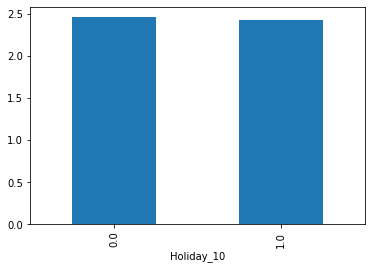

In [76]:
df_sub.groupby('Holiday_10')['Volume Sold (Gallons)'].mean().plot.bar()

There looks to be no difference in the mean volume of alcohol purchased by liquor stores 10 days before a holiday compared to other days.

## Client B Final Datasets

Model1 dataset has the aggregated response variables for each unique city and date combination

In [77]:
df_model1 = df_sub.groupby(['City','Pop_Bracket', 'Date', 'season', 'major_college_town','Holiday_10','DayofWeek']).sum(['Bottles Sold','Sale (Dollars)','Volume Sold (Gallons)'])[['Bottles Sold','Sale (Dollars)','Volume Sold (Gallons)']].reset_index()

In [78]:
df_model1.head()

,City,Pop_Bracket,Date,season,major_college_town,Holiday_10,DayofWeek,Bottles Sold,Sale (Dollars),Volume Sold (Gallons)
0,ackley,2,2020-01-07,winter,0,0.0,Tuesday,90.0,1087.80,24.32
1,ackley,2,2020-01-28,winter,0,0.0,Tuesday,141.0,1934.28,26.07
2,ackley,2,2020-02-04,winter,0,0.0,Tuesday,126.0,1203.24,30.45
3,ackley,2,2020-02-11,winter,0,0.0,Tuesday,90.0,1202.82,28.90
4,ackley,2,2020-02-25,winter,0,0.0,Tuesday,149.0,2084.16,48.18


Model2 dataset is similar to Model1 expect there is the additonal grouping of category name. This means each observation represents a unique city, date, and alcohol cateogry combination.

In [79]:
df_model2 = df_sub.groupby(['City','Pop_Bracket', 'Category Name', 'Date', 'season', 'major_college_town','Holiday_10','DayofWeek']).sum(['Bottles Sold','Sale (Dollars)','Volume Sold (Gallons)'])[['Bottles Sold','Sale (Dollars)','Volume Sold (Gallons)']].reset_index()

In [80]:
df_model2.head()

,City,Pop_Bracket,Category Name,Date,season,major_college_town,Holiday_10,DayofWeek,Bottles Sold,Sale (Dollars),Volume Sold (Gallons)
0,ackley,2,bourbon,2020-09-29,fall,0,0.0,Tuesday,1.0,20.25,0.19
1,ackley,2,bourbon,2022-07-26,summer,0,0.0,Tuesday,12.0,180.00,2.37
2,ackley,2,brandy,2020-01-07,winter,0,0.0,Tuesday,6.0,96.66,0.59
3,ackley,2,brandy,2020-06-30,summer,0,1.0,Tuesday,12.0,197.88,1.18
4,ackley,2,brandy,2021-10-05,fall,0,0.0,Tuesday,12.0,206.88,1.18


## Custom Multiple Regression Functions

In [81]:
def multiple_regression_ridge(X, Y, lam, intercept=True):
    if intercept:
        X = pd.concat([pd.Series([1]*X.shape[0]), X], axis=1).to_numpy()
    else:
        X = X.to_numpy()
    Y = Y.to_numpy()
    return np.linalg.inv((X.T @ X) + lam*np.identity(X.shape[1])) @ X.T @ Y

def try_many_lambdas(X, Y, lams, intercept):
    lams = np.array(lams)
    return [multiple_regression_ridge(X, Y, lam, intercept) for lam in lams]

def tune_lambda_split(train_x, train_y, test_x, test_y, lams, intercept, metric):
    
    df_res = pd.DataFrame()
    df_res['lambda'] = lams
    vals = [0]*len(lams)
    est = try_many_lambdas(train_x, train_y, lams, intercept)
    
    for i in range(len(est)):
        
        if intercept:
            y_hat = pd.Series(pd.concat([pd.Series([1]*test_x.shape[0]), test_x], axis=1).to_numpy() @ est[i])
        else:
            y_hat = pd.Series(test_x.to_numpy() @ est[i])
        
        if metric == 'R_sq':
            y_bar = test_y.mean()
            vals[i] = 1-((((test_y-y_hat)**2).mean())/(((test_y-y_bar)**2).mean()))
            
        elif metric == 'MSE':
            vals[i] = (np.square(test_y-y_hat)).mean()
            
        elif metric == 'MAE':
            vals[i] = (np.abs(test_y-y_hat)).mean()
            
        else:
            print('Please use valid metric :)')

    df_res[metric] = vals
    return df_res

def tune_lambda_cv(X, Y, lams, intercept, metric, splits):
    df_res = pd.DataFrame(columns=['lambda', metric])
    kf = KFold(n_splits=splits, shuffle=True)
    splits = kf.split(X)
    for train, test in splits:
        
        train_x = X.iloc[train].reset_index(drop=True)
        train_y = Y.iloc[train].reset_index(drop=True)
        
        test_x = X.iloc[test].reset_index(drop=True)
        test_y = Y.iloc[test].reset_index(drop=True)

        df_res = pd.concat([df_res, tune_lambda_split(train_x, train_y, test_x, test_y, lams, intercept, metric)])
    return df_res.groupby('lambda')[metric].mean()

## Variable Tuning

We will not be tuning the variables like we did for client A. Rather we want to fit models with most/if not all variables so we can interpret the coefficients of the predictors while taking into account other predictors to see if they are significant. 

### Model1

In [82]:
model1_vars = ['Pop_Bracket', 'season', 'DayofWeek', 'major_college_town', 'Holiday_10']

In [83]:
ct = make_column_transformer(
(OneHotEncoder(), ['Pop_Bracket', 'season', 'DayofWeek']), remainder='passthrough')

In [84]:
X = df_model1[model1_vars]
Y = df_model1['Volume Sold (Gallons)']

Sometimes ct.fit_transform(X) returns a sparse matrix and sometimes it doesnt. It's really annoying. If it does return a sparse matrix, run the second line of code with the .toarray() function. If it doesn't return a sparse matrix, run the top line.

In [85]:
# X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0,6,10], axis=1)
X = pd.DataFrame(ct.fit_transform(X).toarray()).drop(columns=[0,6,10], axis=1)

In [86]:
tune_lambda_cv(X, Y, [0,.1,1,5,100,1000], True, 'R_sq', 5)

lambda
0.0       0.430663
0.1       0.430663
1.0       0.430665
5.0       0.430666
100.0     0.428001
1000.0    0.358638
Name: R_sq, dtype: float64

In [87]:
multiple_regression_ridge(X,Y,100,True)

array([ 2.58853120e+01,  9.11415483e+01,  3.00219133e+02,  4.68027779e+02,
        1.05406429e+03,  1.78516326e+03,  4.17994606e+00,  3.03472559e+00,
       -1.27653045e+01,  2.33920551e+01, -7.47497490e-01, -4.94499561e+02,
        1.67856723e+02,  2.33812379e+01,  8.23680121e+01, -1.86587667e+02,
        2.00174063e+01])

### Model2

The code below is an example of narrowing the model to look at whiskey alone. This means we can use df_model2 to examine how the different predictors affect the volume of alcohol of a specific category purchased by a store.

This means we can answer questions like:

* Do holidays have a larger impact on the consumption of whiskey vs rum?
* Does the presence of a large college have a different impact on the consumption of vodka vs tequila?

In [88]:
df_model2['Category Name'].unique()

array(['bourbon', 'brandy', 'cocktail', 'gin', 'liqueur', 'other', 'rum',
       'schnapps', 'spirit', 'tequila', 'vodka', 'whiskey', 'scotch'],
      dtype=object)

In [89]:
whiskey = df_model2[df_model2['Category Name'] == 'whiskey']

In [90]:
model2_vars = ['Pop_Bracket', 'season', 'DayofWeek', 'major_college_town', 'Holiday_10']

In [91]:
ct = make_column_transformer(
(OneHotEncoder(), ['Pop_Bracket', 'season', 'DayofWeek']), remainder='passthrough')

In [92]:
X = df_model2[model2_vars]
Y = df_model2['Volume Sold (Gallons)']

In [93]:
# X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0,6,10], axis=1)
X = pd.DataFrame(ct.fit_transform(X).toarray()).drop(columns=[0,6,10], axis=1)

In [94]:
tune_lambda_cv(X, Y, [0,.1,1,5,100,1000], True, 'R_sq', 5)

lambda
0.0       0.132629
0.1       0.132629
1.0       0.132629
5.0       0.132629
100.0     0.132616
1000.0    0.131597
Name: R_sq, dtype: float64

In [95]:
multiple_regression_ridge(X,Y,100,True)

array([  4.36435539,  11.81860981,  30.82599832,  50.96015701,
       107.96426096, 156.53346832,  -0.66450499,  -0.37341522,
        -2.50502532,   3.40819872,  -2.39032555, -63.28920499,
        17.29620779,   0.93549515,   7.35262632, -27.9094589 ,
         2.10131032])

## Summary of Model Decisions

In this codebook we:
    
1. Feature Engineered many new variables to interpret in our model
2. Created two different datasets to use for models
3. One dataset can be used to see the effects of the predictors on overal alcohol volume purchased
4. The other dataset can be used to see the effects of the predictors on volume purchased for a specific category of alcohol